### Week 4 project
要求分别建立浅层神经网络（2 layer）和深层神经网络，完成FP BP过程，最终比较两个模型的效果

### 库文件

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import testCases
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward
import lr_utils


# 验证结果 使用seed
np.random.seed(1)



### 初始化参数
先完成浅层神经网络的参数初始化：

In [4]:
def init_params(n_x,n_h,n_y):
    """
    init_params用于初始化浅层NN的参数
    函数参数：
        n_x - 输入层单元数
        n_h - 隐藏层单元数
        n_y - 输出层单元数
    返回结果：
        params - 包含W1,W2,b1,b2参数的字典
    """
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    params = {
        "W1":W1,
        "b1":b1,
        "W2":W2,
        "b2":b2
    }
    return params

测试：

In [5]:
print("=============Test init_params==============")
params = init_params(3,2,1)
print("W1: "+str(params["W1"]))
print("b1: "+str(params["b1"]))
print("W2: "+str(params["W2"]))
print("b2: "+str(params["b2"]))

=============Test init_params==============
W1: [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1: [[0.]
 [0.]]
W2: [[ 0.01744812 -0.00761207]]
b2: [[0.]]


In [6]:
def init_params_deep(layer_dims):
    """
    参数:
        layer_dims:列表结构，存有每层的单元个数
    返回：
        params: 存有W b的字典参数
    """
    np.random.seed(3)
    params={}
    for i in range(1,len(layer_dims)):
        params["W"+str(i)] = np.random.randn(layer_dims[i],layer_dims[i-1])*0.01
        params["b"+str(i)] = np.zeros((layer_dims[i],1))
    return params

测试init_params_deep

In [7]:
layer_dims = [5,4,3]
params = init_params_deep(layer_dims)
print("W1: "+str(params["W1"]))
print("b1: "+str(params["b1"]))
print("W2: "+str(params["W2"]))
print("b2: "+str(params["b2"]))

W1: [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1: [[0.]
 [0.]
 [0.]
 [0.]]
W2: [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2: [[0.]
 [0.]
 [0.]]


### Forward prop

In [8]:
def linear_forward(A,W,b):
    Z = np.dot(W,A)+b
    cache = (A,W,b)
    return Z,cache

测试linear_forward

In [9]:
A,W,b = testCases.linear_forward_test_case()
Z,linear_cache = linear_forward(A,W,b)
print("Z : "+str(Z))

Z : [[ 3.26295337 -1.23429987]]


In [10]:
def linear_activation_forward(A_prev,W,b,activation):
    """
    返回：
        A - activation后的结果
        cache - 包含linear_cache(A,W,b)和activation cache(Z)
    """
    Z,linear_cache = linear_forward(A_prev,W,b)
    if activation == "sigmoid":
        A,activation_cache = sigmoid(Z)
    elif activation == "relu":
        A,activation_cache = relu(Z)
    
    cache = (linear_cache,activation_cache)
    return A,cache

测试Linear_activation_forward

In [11]:
A_prev,W,b = testCases.linear_activation_forward_test_case()
A,cache = linear_activation_forward(A_prev,W,b,activation="sigmoid")
print("sigmoid A="+str(A))
A,cache = linear_activation_forward(A_prev,W,b,activation="relu")
print("relu A="+str(A))


sigmoid A=[[0.96890023 0.11013289]]
relu A=[[3.43896131 0.        ]]


In [12]:
def L_model_forward(X,params):
    """
    返回：
        AL - 最后一层的输出
        caches - 包含每层的cache
    """
    caches = []
    layer_num = len(params)//2
    A = X
    for i in range(1,layer_num):
        A_prev = A
        A, cache= linear_activation_forward(A_prev,params["W"+str(i)],params["b"+str(i)],activation="relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A,params["W"+str(layer_num)],params["b"+str(layer_num)],activation="sigmoid")
    caches.append(cache)
    return AL,caches

测试L_model_forward

In [13]:
X,params = testCases.L_model_forward_test_case()
AL,caches = L_model_forward(X,params)
print("AL = "+str(AL))
print("caches length: "+ str(len(caches)))

AL = [[0.17007265 0.2524272 ]]
caches length: 2


### 计算cost

In [14]:
def compute_cost(AL,Y):
    m = Y.shape[1]
    temp = np.multiply(np.log(AL),Y)+np.multiply(np.log(1-AL),1-Y)
    cost = -np.sum(temp)/m
    cost = np.squeeze(cost)
    return cost

测试compute_cost

In [15]:
Y,AL = testCases.compute_cost_test_case()
cost = compute_cost(AL,Y)
print("cost = "+str(cost))

cost = 0.414931599615397


### BP

In [16]:
def linear_backward(dZ,cache):
    """
    linear_backward用于根据dZ[l]计算dA[l-1],dW[l],db[l]
    """
    A_prev,W,b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev,dW,db
    

测试linear_backward:

In [17]:
dZ,cache = testCases.linear_backward_test_case()
dA_prev, dW, db = linear_backward(dZ,cache)
print("dA_prev: "+str(dA_prev))
print("dW: "+str(dW))
print("db: "+str(db))


dA_prev: [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW: [[-0.10076895  1.40685096  1.64992505]]
db: [[0.50629448]]


In [18]:
def linear_activation_backward(dA,caches,activation="relu"):
    """
    参数：
        dA - 略
        caches - 包含linear_cache和activation_cache
        activation - 略
    返回：
        dA_prev, dW, db
    """
    linear_cache, activation_cache = caches
    if activation=="relu":
        dZ = relu_backward(dA,activation_cache)
    elif activation=="sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
    return linear_backward(dZ,linear_cache)

In [19]:
#测试linear_activation_backward
print("==============测试linear_activation_backward==============")
AL, linear_activation_cache = testCases.linear_activation_backward_test_case()
 
dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")
 
dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))


==============测试linear_activation_backward==============
sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989 -0.        ]
 [ 0.37883606 -0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


In [20]:
def L_model_backward(AL,Y,caches):
    """
    返回：
        grads - 包含各层dW，db的字典
    """
    grads = {}
    dAL = -(np.divide(Y,AL) - np.divide(1-Y,1-AL))
    grads["dAL"] = dAL
    L = len(caches)
    dA_prev,dW,db= linear_activation_backward(dAL,caches[L-1],activation="sigmoid")
    grads["dW"+str(L)] = dW
    grads["db"+str(L)] = db
    grads["dA"+str(L-1)] = dA_prev
    i = L-1
    while(i>=1):
        dA = dA_prev
        dA_prev,dW,db = linear_activation_backward(dA,caches[i-1],activation="relu")
        grads["dW"+str(i)] = dW
        grads["db"+str(i)] = db
        grads["dA"+str(i-1)] = dA_prev
        i = i - 1
    return grads

In [21]:
#测试L_model_backward
print("==============测试L_model_backward==============")
AL, Y_assess, caches = testCases.L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))


==============测试L_model_backward==============
dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]


### Gradient Descent

In [22]:
def update_params(params,grads,learning_rate):
    layer_num = len(params) // 2
    for i in range(1,layer_num+1):
        params["W"+str(i)] = params["W"+str(i)] - learning_rate * grads["dW"+str(i)]
        params["b"+str(i)] = params["b"+str(i)] - learning_rate * grads["db"+str(i)]
    return params    

测试梯度下降

In [24]:
#测试update_parameters
print("==============测试update_parameters==============")
parameters, grads = testCases.update_parameters_test_case()
parameters = update_params(parameters, grads, 0.1)
 
print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))



==============测试update_parameters==============
W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


In [32]:
def two_layer_model(X,Y,layer_dims,learning_rate=0.0075,num_iterations=3000,print_cost=False,isPlot=True):
    np.random.seed(1)
    grads={}
    costs=[]
    (n_x,n_h,n_y) = layer_dims
    
    params = init_params(n_x,n_h,n_y)
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    for i in range(num_iterations):
        A1,cache1 = linear_activation_forward(X,W1,b1,"relu")
        A2,cache2 = linear_activation_forward(A1,W2,b2,"sigmoid")
        
        cost = compute_cost(A2,Y)
        
        dA2 = -(np.divide(Y,A2) - np.divide(1-Y,1-A2))
        dA1,dW2,db2 = linear_activation_backward(dA2,cache2,"sigmoid")
        dA0,dW1,db1 = linear_activation_backward(dA1,cache1,"relu")
        
        grads = {
            "dW1":dW1,
            "db1":db1,
            "dW2":dW2,
            "db2":db2
        }
        params = update_params(params,grads,learning_rate)
        W1 = params["W1"]
        W2 = params["W2"]
        b1 = params["b1"]
        b2 = params["b2"]
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("Iteration "+str(i)+" cost:"+str(cost))
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel("cost")
        plt.xlabel("#Iteration")
        plt.title("Learning Rate = "+str(learning_rate))
        plt.show()
    return params
    
        
        

### 加载数据

In [33]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y



### 使用两层网络训练

Iteration 0 cost:0.6930497356599891
Iteration 100 cost:0.6464320953428849
Iteration 200 cost:0.6325140647912677
Iteration 300 cost:0.6015024920354665
Iteration 400 cost:0.5601966311605748
Iteration 500 cost:0.515830477276473
Iteration 600 cost:0.47549013139433266
Iteration 700 cost:0.4339163151225749
Iteration 800 cost:0.40079775362038855
Iteration 900 cost:0.3580705011323797
Iteration 1000 cost:0.33942815383664127
Iteration 1100 cost:0.3052753636196264
Iteration 1200 cost:0.2749137728213016
Iteration 1300 cost:0.2468176821061484
Iteration 1400 cost:0.19850735037466108
Iteration 1500 cost:0.17448318112556646
Iteration 1600 cost:0.17080762978095992
Iteration 1700 cost:0.1130652456216474
Iteration 1800 cost:0.09629426845937158
Iteration 1900 cost:0.0834261795972687
Iteration 2000 cost:0.07439078704319084
Iteration 2100 cost:0.06630748132267934
Iteration 2200 cost:0.05919329501038174
Iteration 2300 cost:0.05336140348560556
Iteration 2400 cost:0.048554785628770185


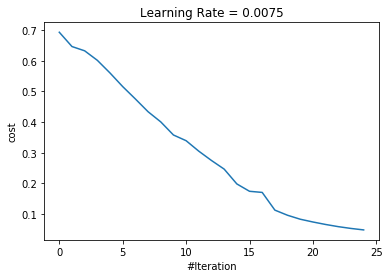

In [34]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)

parameters = two_layer_model(train_x, train_set_y, layers_dims,0.0075,num_iterations = 2500, print_cost=True,isPlot=True)




### 预测

In [35]:
def predict(X,y,params):
    m = X.shape[1]
    p = np.zeros((1,m))
    
    probas,caches = L_model_forward(X,params)
    
    for i in range(m):
        if(probas[0,i]>0.5):
            p[0,i] = 1
        else:
            p[0,i] = 0
    acc = (np.sum(p==y))/m
    print("Accuracy :"+str(acc))
    return p


In [36]:
predictions_train = predict(train_x, train_y, parameters) #训练集
predictions_test = predict(test_x, test_y, parameters) #测试集


Accuracy :1.0
Accuracy :0.72


### 多层神经网络

In [51]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False,isPlot=True):

    np.random.seed(1)
    costs = []
    
    parameters = init_params_deep(layers_dims)
    
    for i in range(0,num_iterations):
        AL , caches = L_model_forward(X,parameters)
        
        cost = compute_cost(AL,Y)
        
        grads = L_model_backward(AL,Y,caches)
        
        parameters = update_params(parameters,grads,learning_rate)
        

        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))

    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters


### 加载数据



In [57]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

print(train_x.shape)
print(train_x)

(12288, 209)
[[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]


### 训练模型

第 0 次迭代，成本值为： 0.6931477726958
第 100 次迭代，成本值为： 0.6780107728090446
第 200 次迭代，成本值为： 0.6675997530076284
第 300 次迭代，成本值为： 0.6604218729413204
第 400 次迭代，成本值为： 0.6554578158288099
第 500 次迭代，成本值为： 0.6520134603618388
第 600 次迭代，成本值为： 0.649615817609133
第 700 次迭代，成本值为： 0.6479417374612982
第 800 次迭代，成本值为： 0.6467696408278703
第 900 次迭代，成本值为： 0.6459469904244376
第 1000 次迭代，成本值为： 0.6453683565180597
第 1100 次迭代，成本值为： 0.6449605941011141
第 1200 次迭代，成本值为： 0.6446727774747648
第 1300 次迭代，成本值为： 0.6444693397903307
第 1400 次迭代，成本值为： 0.6443253714906714
第 1500 次迭代，成本值为： 0.6442233840298892
第 1600 次迭代，成本值为： 0.6441510728582549
第 1700 次迭代，成本值为： 0.6440997647032186
第 1800 次迭代，成本值为： 0.6440633362006798
第 1900 次迭代，成本值为： 0.6440374583192077
第 2000 次迭代，成本值为： 0.6440190669815907
第 2100 次迭代，成本值为： 0.6440059911782885
第 2200 次迭代，成本值为： 0.6439966916973487
第 2300 次迭代，成本值为： 0.6439900760641626
第 2400 次迭代，成本值为： 0.6439853685643353


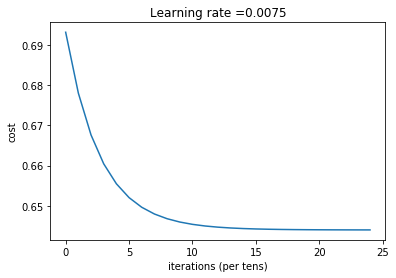

In [58]:
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, 0.0075,num_iterations = 2500,print_cost = True,isPlot=True)

